In [1]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xzf /content/facades.tar.gz

--2020-12-13 12:52:02--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.189.73
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.189.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz.3’

facades.tar.gz.3    100%[===================>]  28.77M   747KB/s    in 21s     

2020-12-13 12:52:24 (1.34 MB/s) - ‘facades.tar.gz.3’ saved [30168306/30168306]



In [2]:
#!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/edges2handbags.tar.gz
#!tar -xzf /content/edges2handbags.tar.gz

In [3]:
!pip install wandb

In [4]:
!ls /content/facades/train | wc -l

400


In [5]:
!wandb login ee9416edde558c322450d0ec80266d2c0db81f45

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import os
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models
import random
from tqdm.notebook import tqdm

from PIL import Image
import numpy as np

class ImgDataset(Dataset):
    
    def __init__(self, root, folder, transform=None):
        super(ImgDataset).__init__()
        self.root = os.path.join(root, folder)
        self.files = os.listdir(self.root)
        
    def __getitem__(self, idx):
        filepath = os.path.join(self.root, self.files[idx])
        img = Image.open(filepath)
        img = transforms.ToTensor()(img)
        img = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(img)
        width = img.shape[2]
        x, y = img[:, :, width // 2 :], img[:, :, : width // 2] # for facades
        x, y = self.transform(x, y)
        return x, y


    def __len__(self):
        return len(self.files)

    def transform(self, x, y):
        new_h, new_w = 286, 286
        resize = transforms.Resize(size=(new_h, new_w))
        x, y = resize(x), resize(y)

        i, j, h, w = transforms.RandomCrop.get_params(
            x, output_size=(256, 256))
        x = transforms.functional.crop(x, i, j, h, w)
        y = transforms.functional.crop(y, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            x = transforms.functional.hflip(x)
            y = transforms.functional.hflip(y)

        return x, y


def make_loader(root, modes=['train', 'val', 'test'], bs=512):
    loaders = []
    for mode, batch_size in zip(modes, [bs, 2, 2]):
	      dataset = ImgDataset(root, mode)
	      loaders.append(DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=1, pin_memory=True))
    return loaders

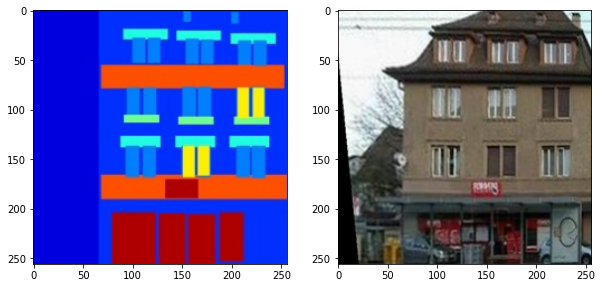

In [7]:
import matplotlib.pyplot as plt
def my_imshow(inp, tar):
    """Imshow for Tensor."""
    inp = transforms.Normalize((-1.0, -1.0, -1.0), (2.0, 2.0, 2.0))(inp)
    tar = transforms.Normalize((-1.0, -1.0, -1.0), (2.0, 2.0, 2.0))(tar)
    inp = transforms.ToPILImage()(inp)
    tar = transforms.ToPILImage()(tar)    
    
    f, axarr = plt.subplots(1, 2) 
    f.set_figheight(5)
    f.set_figwidth(10)
    
    axarr[0].imshow(inp)
    axarr[1].imshow(tar)
root = '/content/facades'
#root = '/content/edges2handbags'
dataset = ImgDataset(root, 'train')
for x, y in dataset:
  break

my_imshow(x, y)

In [8]:
#https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, checkpoint, patience=7, verbose=False, delta=0, min_loss=np.inf):
        """
        :param
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None if min_loss == np.inf else  -min_loss
        self.early_stop = False
        self.val_loss_min = min_loss
        self.delta = delta
        self.checkpoint = checkpoint

    def __call__(self, val_loss, model, optimizer, scheduler):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, scheduler)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, scheduler)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer, scheduler):
        """
        Saves model when validation loss decrease.
        """
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': val_loss
            }, self.checkpoint)

        self.val_loss_min = val_loss



def seed_torch(seed=1):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    n_gpu = torch.cuda.device_count()
    if n_gpu > 0:
        torch.cuda.manual_seed_all(seed)

In [9]:
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Config:
    up: List[Tuple[int, int]]
    down: List[Tuple[int, int]]
    discriminator: List[Tuple[int, int]]
    dropout_p: List[float]
    n_layers: int
    discriminator_layers: int
    lmbd: float
    epochs: int
    device: 'torch.device' = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

config = Config(
    [(512, 512), (1024, 512), (1024, 512), (1024, 512),  (1024, 512), (768, 512), (640, 256), (320, 128)],
    [(512, 512), (512, 512), (512, 512), (512, 512), (256, 512), (128, 256), (64, 128), (3, 64)],
    [(6, 64), (64, 128), (128, 256), (256, 512)],
    [0.5, 0.5, 0.5, 0, 0, 0, 0, 0],
    8, 4, 100, 150
)


In [10]:
class ConvBlock(nn.Module):

  def __init__(self, in_channels, out_channels, is_top=False):
      super(ConvBlock, self).__init__()
      self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
      self.batch_norm = nn.BatchNorm2d(out_channels) if not is_top else nn.Identity()
      self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)


  def forward(self, x):
      in_shape = x.shape
      x = self.batch_norm(self.conv(x))
      x = self.leaky_relu(x)
      return x


class ConvTBlock(nn.Module):

  def __init__(self, in_channels, out_channels, dropout_p=0):
      super(ConvTBlock, self).__init__()
      self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
      self.batch_norm = nn.BatchNorm2d(out_channels)
      self.relu = nn.ReLU(inplace=True)
      self.dropout_p = dropout_p

  def forward(self, x):
      in_shape = x.shape
      x = self.batch_norm(self.conv(x))
      x = F.dropout(x, p=self.dropout_p)
      x = self.relu(x)
      return x


class UNetLayer(nn.Module):

    def __init__(self, config, subnet, i):

        super(UNetLayer, self).__init__()
        is_bottom = i == 0
        self.is_top = i == config.n_layers - 1

        down = ConvBlock(*config.down[i], self.is_top)
        up = ConvTBlock(*config.up[i], config.dropout_p[i])

        if is_bottom:
            self.net = nn.Sequential(down, up)
        else:
            self.net = nn.Sequential(down, subnet, up)

    def forward(self, x):
        if self.is_top:
            return self.net(x)
        else:
            return torch.cat([x, self.net(x)], 1)


class UNet(nn.Module):

  def __init__(self, config):
      super(UNet, self).__init__()
      net = UNetLayer(config, None, 0)
      for i in range(1, config.n_layers):
          net = UNetLayer(config, net, i)
      self.net = nn.Sequential(
          net,
          nn.Conv2d(config.up[-1][-1], 3, kernel_size=1),
          nn.Tanh()
      )

  def forward(self, x):
      return self.net(x)


class Discriminator(nn.Module):

  def __init__(self, config):
      super(Discriminator, self).__init__()
      n_layers = config.discriminator_layers
      self.layers = nn.ModuleList(
           [ConvBlock(*config.discriminator[i], i == 0) for i in  range(n_layers)]
      )
      chanels_out = config.discriminator[-1][-1]
      self.final = nn.Conv2d(chanels_out, 1, kernel_size=4, padding=1)

  def forward(self, x):
      for layer in self.layers:
          x = layer(x)
      x = self.final(x)
      return x
      

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
def train(config, models, optimizers, schedulers, train_loader, val_loader=None):
    epochs = config.epochs

    gan_criterion = torch.nn.BCEWithLogitsLoss().to(config.device)
    reg_criterion = torch.nn.L1Loss().to(config.device)
    criterions = [gan_criterion, reg_criterion]

    for epoch in range(epochs):
        gen_train_loss, disc_train_loss = train_epoch(config, train_loader, models, optimizers, criterions)
        gen_val_loss, disc_val_loss = val_epoch(config, val_loader, models, criterions, epoch)

        checkpoint = f'./checkpoint_lmbd_{config.lmbd}.pt'
        torch.save({
            'generator_state_dict': models[0].state_dict(),
            'discriminator_state_dict': models[1].state_dict(),
            'gen_opt': optimizers[0].state_dict(),
            'disc_opt': optimizers[1].state_dict()
            }, checkpoint)
        #wandb.save(checkpoint)

        #schedulers[0].step(gen_val_loss)
        #schedulers[1].step(disc_val_loss)


def train_epoch(config, train_loader, models, optimizers, criterions):
    G, D = models
    G.train()
    D.train()
    gen_tr_loss = 0
    disc_tr_loss = 0
    tr_steps = 0
    device = config.device

    gan_criterion, reg_criterion = criterions
    G_opt, D_opt = optimizers
    for batch in tqdm(train_loader):
          x, y = batch
          x = x.to(device)
          y = y.to(device, non_blocking=True)
          fake = G(x)
          fake_c = torch.cat((x, fake), 1)
          fake_pred = D(fake_c)
          gen_loss = gan_criterion(fake_pred, torch.ones_like(fake_pred)) + config.lmbd * reg_criterion(fake, y)
          gen_tr_loss += gen_loss.item()
          G_opt.zero_grad()
          gen_loss.backward()
          torch.nn.utils.clip_grad_norm_(G.parameters(), 20.0)
          G_opt.step()

          fake = G(x)
          fake_c, real_c = torch.cat((x, fake.detach()), 1), torch.cat((x, y), 1)
          fake_pred, real_pred = D(fake_c), D(real_c)
          disc_loss = 0.75 * (gan_criterion(fake_pred, torch.zeros_like(fake_pred)) + \
                             gan_criterion(real_pred, torch.ones_like(real_pred)))
          disc_tr_loss += disc_loss.item()
          D_opt.zero_grad()
          disc_loss.backward()
          torch.nn.utils.clip_grad_norm_(D.parameters(), 20.0)
          D_opt.step()
          tr_steps += 1
          wandb.log({'generator_loss/train' : gen_tr_loss / tr_steps, 
                    'discriminator_loss/train': disc_tr_loss / tr_steps})
    return gen_tr_loss / tr_steps, disc_tr_loss / tr_steps
                

@torch.no_grad()         
def val_epoch(config, val_loader, models, criterions, epoch):
    G, D = models
    G.train()
    D.eval()
    gen_val_loss = 0
    disc_val_loss = 0
    val_steps = 0
    device = config.device

    gan_criterion, reg_criterion = criterions

    to_img = transforms.Compose([
        transforms.Normalize(mean=(-1.0, -1.0, -1.0), std=(2.0, 2.0, 2.0)),
        transforms.ToPILImage()
    ])
    for batch in tqdm(val_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device, non_blocking=True)
        fake = G(x)
        fake_c = torch.cat((x, fake), 1)
        real_c = torch.cat((x, y), 1)

        fake_pred = D(fake_c)
        gen_loss = gan_criterion(fake_pred, torch.ones_like(fake_pred)) + config.lmbd * reg_criterion(fake, y)
        gen_val_loss += gen_loss.item()

        fake_c, real_c = torch.cat((x, fake.detach()), 1), torch.cat((x, y), 1)
        fake_pred, real_pred = D(fake_c), D(real_c)
        disc_loss = 0.75 * (gan_criterion(fake_pred, torch.zeros_like(fake_pred)) + \
                             gan_criterion(real_pred, torch.ones_like(real_pred)))
        disc_val_loss += disc_loss.item()
        val_steps += 1
    b_sz = x.shape[0]
    wandb.log({'generator_loss/val' : gen_val_loss /val_steps, 
                'discriminator_loss/val': disc_val_loss / val_steps,
               "Generated": [wandb.Image(to_img(fake[i].cpu().detach()), caption=f'epoch: {epoch}') for i in range(b_sz)],
               "Input": [wandb.Image(to_img(x[i].cpu().detach()), caption=f'epoch: {epoch}') for i in range(b_sz)],
               "Ground Truth": [wandb.Image(to_img(y[i].cpu().detach()), caption=f'epoch: {epoch}') for i in range(b_sz)],
               })
    return gen_val_loss / val_steps, disc_val_loss / val_steps

In [ ]:
SEED=1992
seed_torch(SEED)
for lmbd in [10, 50, 100, 150]:
    wandb.init(project='dl hw3', name=f'aug facades, lmbd={lmbd}', config=config)
    config.lmbd = lmbd

    generator = UNet(config).to(config.device)
    discriminator = Discriminator(config).to(config.device)
    models = [generator, discriminator]

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=4e-4, weight_decay=1e-6)
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=4e-4, weight_decay=1e-6)
    optimizers = [optimizer_G, optimizer_D]

    scheduler_G = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_G, patience=3, factor=0.75)
    scheduler_D = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_D, patience=3, factor=0.75)
    schedulers = [scheduler_G, scheduler_D]

    train_loader, val_loader = make_loader(root, modes=['train', 'val'], bs=16)
    train(config, models, optimizers, schedulers, train_loader, val_loader)
    wandb.join()

wandb: Currently logged in as: arinaruck (use `wandb login --relogin` to force relogin)
